In [1]:
cd /content/drive/MyDrive/[Projects]/AI Hub/Pose Detection 기반 실시간 낙상 감지 시스템 개발/Data

/content/drive/MyDrive/[Projects]/AI Hub/Pose Detection 기반 실시간 낙상 감지 시스템 개발/Data


In [2]:
import random

def fix_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
import pandas as pd
import numpy as np

def load_csv(csv_path):
    df = pd.read_csv(csv_path)
    df.sort_values(["file", "frame"], inplace=True)
    return df


def make_sequences(df, window_size=30, step=1):
    x = []
    y = []

    # 파일별 그룹 추출
    for file, group in df.groupby("file"):
        data = group.drop(columns=["file", "frame", "label"]).values
        labels = group["label"].values

        # 순차 슬라이딩 윈도우
        for i in range(0, len(data) - window_size + 1, step):
            seq = data[i:i+window_size]
            target = 1 if np.sum(labels[i:i+window_size]) > 0 else 0

            x.append(seq)
            y.append(target)

    return np.array(x), np.array(y)


In [4]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=51, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        _, (h, _) = self.lstm(x)
        return self.fc(h[-1])

In [5]:
from torch.utils.data import TensorDataset, DataLoader

def train_model(x, y, x_val, y_val, epochs=10, batch_size=64, lr=1e-3):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMModel().to(device)

    num_pos = y.sum()
    num_neg = len(y) - num_pos
    pw = num_neg / num_pos

    pos_weight = torch.tensor([pw], device=device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    optim = torch.optim.Adam(model.parameters(), lr=lr)

    train_ds = TensorDataset(
        torch.tensor(x).float(),     # CPU 유지
        torch.tensor(y).float()
    )
    val_ds = TensorDataset(
        torch.tensor(x_val).float(),
        torch.tensor(y_val).float()
    )

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):

        model.train()
        total_loss = 0

        for seq, label in train_loader:

            seq = seq.to(device)          # 여기서만 GPU
            label = label.to(device)

            logits = model(seq).squeeze()
            loss = loss_fn(logits, label)

            optim.zero_grad()
            loss.backward()
            optim.step()

            total_loss += loss.item()

        print(f"[Epoch {epoch+1}] loss={total_loss/len(train_loader):.4f}")

    return model

In [6]:
from sklearn.metrics import precision_recall_curve

def find_best_threshold(model, x_val, y_val):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    probs = []

    with torch.no_grad():
        for seq in x_val:
            seq = torch.tensor(seq).float().unsqueeze(0).to(device)
            logit = model(seq)
            prob = torch.sigmoid(logit).item()
            probs.append(prob)

    probs = np.array(probs)

    prec, rec, ths = precision_recall_curve(y_val, probs)

    best_f1 = 0
    best_th = 0.5

    for p, r, t in zip(prec, rec, ths):
        f1 = 2 * p * r / (p + r + 1e-8)
        if f1 > best_f1:
            best_f1 = f1
            best_th = t

    return best_th, best_f1


In [7]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


def evaluate(model, x_val, y_val, threshold=0.5):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    preds = []
    probs = []

    loader = DataLoader(
        TensorDataset(
            torch.tensor(x_val).float()
        ),
        batch_size=64,
        shuffle=False
    )

    with torch.no_grad():
        for seq, in loader:
            seq = seq.to(device)

            logits = model(seq).squeeze()
            prob = torch.sigmoid(logits)

            probs.extend(prob.cpu().numpy())
            preds.extend((prob > threshold).cpu().numpy())

    preds = np.array(preds)
    y_val = np.array(y_val)

    cm = confusion_matrix(y_val, preds)
    precision = precision_score(y_val, preds, zero_division=0)
    recall    = recall_score(y_val, preds, zero_division=0)
    f1        = f1_score(y_val, preds, zero_division=0)

    print("\n📌 CONFUSION MATRIx")
    print(f"\nPrecision = {precision:.4f}")
    print(f"Recall    = {recall:.4f}")
    print(f"F1        = {f1:.4f}")

    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=.5)
    plt.show()

    return f1, precision, recall, cm

In [8]:
train_df = load_csv("output_train.csv")
val_df   = load_csv("output_val.csv")

In [9]:
train_df.head()

,file,frame,label,nose_x,nose_y,nose_score,left_eye_x,left_eye_y,left_eye_score,right_eye_x,...,left_knee_score,right_knee_x,right_knee_y,right_knee_score,left_ankle_x,left_ankle_y,left_ankle_score,right_ankle_x,right_ankle_y,right_ankle_score
201048,00002_H_A_N_C1.mp4,0,0,442.274292,302.780212,0.961438,447.320007,294.638428,0.828017,431.255310,...,0.995945,420.807007,516.382324,0.997787,554.010925,628.323120,0.979250,420.376526,659.532959,0.985658
201049,00002_H_A_N_C1.mp4,1,0,440.839233,303.524109,0.964443,446.424835,295.297272,0.850829,429.885437,...,0.995983,420.356689,517.684387,0.997665,555.401550,626.958191,0.980147,420.532806,659.837646,0.985645
201050,00002_H_A_N_C1.mp4,2,0,441.611084,303.199280,0.963709,447.098206,294.915924,0.846917,430.466675,...,0.996007,420.453857,517.431763,0.997671,555.535522,627.419189,0.980225,420.159454,658.446411,0.985696
201051,00002_H_A_N_C1.mp4,3,0,442.712311,306.896973,0.963096,447.724915,298.113525,0.831183,431.603394,...,0.996252,420.279419,517.739868,0.997923,555.691895,627.266602,0.980635,420.072571,656.829224,0.986490
201052,00002_H_A_N_C1.mp4,4,0,446.509247,303.585266,0.965001,449.876373,295.684540,0.762596,435.906067,...,0.997334,422.029663,520.645996,0.998919,552.713440,626.840332,0.985617,423.048767,662.530396,0.991652


In [10]:
val_df.head()

,file,frame,label,nose_x,nose_y,nose_score,left_eye_x,left_eye_y,left_eye_score,right_eye_x,...,left_knee_score,right_knee_x,right_knee_y,right_knee_score,left_ankle_x,left_ankle_y,left_ankle_score,right_ankle_x,right_ankle_y,right_ankle_score
1000,00001_H_A_SY_C1.mp4,0,0,432.507782,301.897675,0.965829,440.708374,293.584564,0.884790,423.292175,...,0.997029,410.709625,464.343903,0.996638,536.149414,632.925842,0.989198,448.847687,658.614075,0.987186
1001,00001_H_A_SY_C1.mp4,1,0,432.910187,304.123962,0.966320,441.175568,295.566284,0.880655,423.673309,...,0.997095,411.179382,466.708618,0.996904,536.719482,632.899475,0.989341,448.511200,658.298096,0.987857
1002,00001_H_A_SY_C1.mp4,2,0,433.168152,305.085907,0.963752,441.193665,296.166718,0.869938,423.771057,...,0.997093,411.892151,466.767395,0.996901,537.091675,632.759094,0.989379,449.215179,658.937134,0.987887
1003,00001_H_A_SY_C1.mp4,3,0,433.140137,305.882416,0.963503,441.051361,296.971436,0.866934,423.764404,...,0.997141,411.414917,467.523193,0.997058,537.204590,632.072815,0.989498,449.638275,659.788635,0.988305
1004,00001_H_A_SY_C1.mp4,4,0,433.314209,306.045380,0.963903,441.114166,296.993317,0.863276,423.847351,...,0.997167,411.140594,467.391479,0.997144,536.405212,632.130249,0.989165,449.199982,659.140015,0.988118


In [11]:
train_df = train_df.interpolate().fillna(0)
val_df = val_df.interpolate().fillna(0)

/tmp/ipython-input-2070354698.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  train_df = train_df.interpolate().fillna(0)
/tmp/ipython-input-2070354698.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  val_df = val_df.interpolate().fillna(0)


In [12]:
window_to_model = {}
window_to_threshold = {}
results = []

[Epoch 1] loss=1.1684
[Epoch 2] loss=1.1233
[Epoch 3] loss=1.0999
[Epoch 4] loss=1.1033
[Epoch 5] loss=1.1012
[Epoch 6] loss=1.0922
[Epoch 7] loss=1.0921
[Epoch 8] loss=1.0872
[Epoch 9] loss=1.0850
[Epoch 10] loss=1.0805
best threshold = 0.6925917863845825

📌 CONFUSION MATRIx

Precision = 0.0000
Recall    = 0.0000
F1        = 0.0000


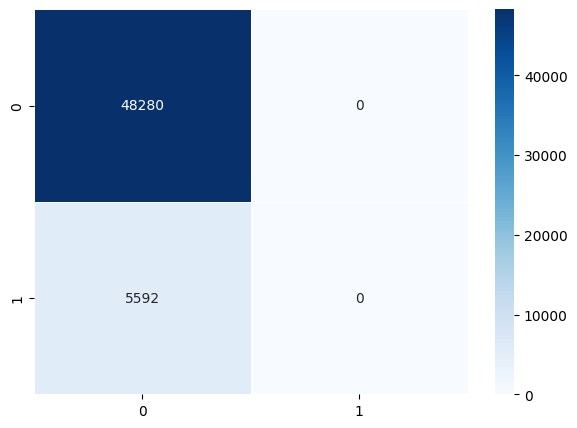

In [13]:
WINDOW = 10

fix_seed(42)

x_train, y_train = make_sequences(train_df, window_size=WINDOW)
x_val, y_val     = make_sequences(val_df, window_size=WINDOW)

model_10 = train_model(x_train, y_train, x_val, y_val)

best_th_10, best_f1 = find_best_threshold(model_10, x_val, y_val)
print("best threshold =", best_th_10)

window_to_model[WINDOW] = model_10
window_to_threshold[WINDOW] = best_th_10

f1, precision, recall, cm = evaluate(model_10, x_val, y_val, threshold=best_th_10)
results.append({
    'Window size': WINDOW,
    'F1-Score': f1,
    'Precision': precision,
    'Recall': recall
})

[Epoch 1] loss=0.9620
[Epoch 2] loss=0.9291
[Epoch 3] loss=0.9116
[Epoch 4] loss=0.9070
[Epoch 5] loss=0.8986
[Epoch 6] loss=0.8959
[Epoch 7] loss=0.8976
[Epoch 8] loss=0.8898
[Epoch 9] loss=0.8882
[Epoch 10] loss=0.8836
best threshold = 0.8010215759277344

📌 CONFUSION MATRIx

Precision = 0.4266
Recall    = 0.0111
F1        = 0.0216


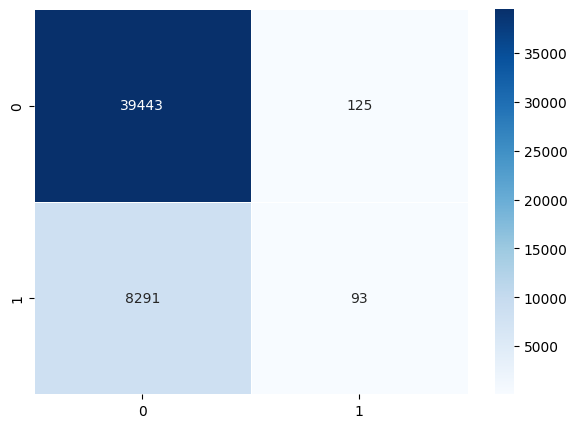

In [14]:
WINDOW = 20

fix_seed(42)

x_train, y_train = make_sequences(train_df, window_size=WINDOW)
x_val, y_val     = make_sequences(val_df, window_size=WINDOW)

model_20 = train_model(x_train, y_train, x_val, y_val)

best_th_20, best_f1 = find_best_threshold(model_20, x_val, y_val)
print("best threshold =", best_th_20)

window_to_model[WINDOW] = model_20
window_to_threshold[WINDOW] = best_th_20

f1, precision, recall, cm = evaluate(model_20, x_val, y_val, threshold=best_th_20)
results.append({
    'Window size': WINDOW,
    'F1-Score': f1,
    'Precision': precision,
    'Recall': recall
})

[Epoch 1] loss=0.7715
[Epoch 2] loss=0.7445
[Epoch 3] loss=0.7209
[Epoch 4] loss=0.7219
[Epoch 5] loss=0.7071
[Epoch 6] loss=0.7059
[Epoch 7] loss=0.7026
[Epoch 8] loss=0.6992
[Epoch 9] loss=0.7038
[Epoch 10] loss=0.6997
best threshold = 0.8033048510551453

📌 CONFUSION MATRIx

Precision = 0.6313
Recall    = 0.8398
F1        = 0.7207


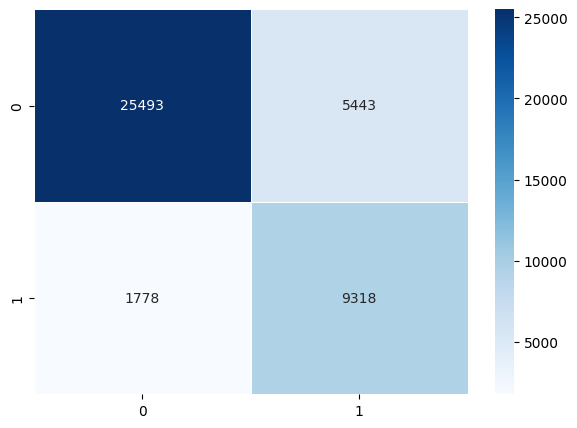

In [15]:
WINDOW = 30

fix_seed(42)

x_train, y_train = make_sequences(train_df, window_size=WINDOW)
x_val, y_val     = make_sequences(val_df, window_size=WINDOW)

model_30 = train_model(x_train, y_train, x_val, y_val)

best_th_30, best_f1 = find_best_threshold(model_30, x_val, y_val)
print("best threshold =", best_th_30)

window_to_model[WINDOW] = model_30
window_to_threshold[WINDOW] = best_th_30

f1, precision, recall, cm = evaluate(model_30, x_val, y_val, threshold=best_th_30)
results.append({
    'Window size': WINDOW,
    'F1-Score': f1,
    'Precision': precision,
    'Recall': recall
})

[Epoch 1] loss=0.6127
[Epoch 2] loss=0.5415
[Epoch 3] loss=0.5255
[Epoch 4] loss=0.5130
[Epoch 5] loss=0.5063
[Epoch 6] loss=0.5117
[Epoch 7] loss=0.5088
[Epoch 8] loss=0.5059
[Epoch 9] loss=0.4987
[Epoch 10] loss=0.4993
best threshold = 0.7422698736190796

📌 CONFUSION MATRIx

Precision = 0.7453
Recall    = 0.9143
F1        = 0.8212


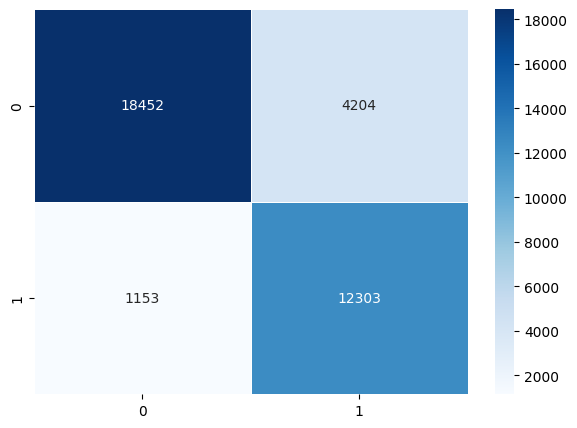

In [16]:
WINDOW = 40

fix_seed(42)

x_train, y_train = make_sequences(train_df, window_size=WINDOW)
x_val, y_val     = make_sequences(val_df, window_size=WINDOW)

model_40 = train_model(x_train, y_train, x_val, y_val)

best_th_40, best_f1 = find_best_threshold(model_40, x_val, y_val)
print("best threshold =", best_th_40)

window_to_model[WINDOW] = model_40
window_to_threshold[WINDOW] = best_th_40

f1, precision, recall, cm = evaluate(model_40, x_val, y_val, threshold=best_th_40)
results.append({
    'Window size': WINDOW,
    'F1-Score': f1,
    'Precision': precision,
    'Recall': recall
})

[Epoch 1] loss=0.3959
[Epoch 2] loss=0.3573
[Epoch 3] loss=0.3426
[Epoch 4] loss=0.3348
[Epoch 5] loss=0.3408
[Epoch 6] loss=0.3307
[Epoch 7] loss=0.3297
[Epoch 8] loss=0.3272
[Epoch 9] loss=0.3274
[Epoch 10] loss=0.3349
best threshold = 0.6559758186340332

📌 CONFUSION MATRIx

Precision = 0.9048
Recall    = 0.9450
F1        = 0.9244


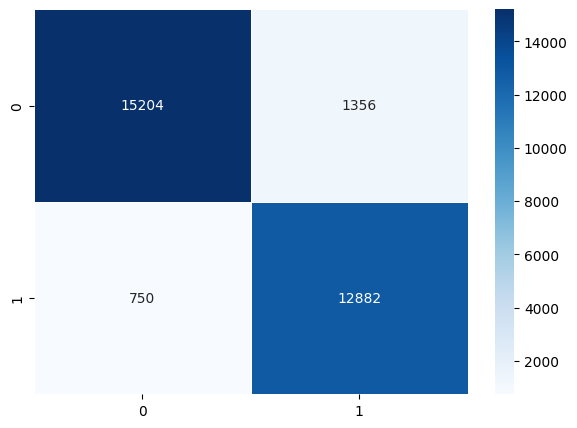

In [17]:
WINDOW = 50

fix_seed(42)

x_train, y_train = make_sequences(train_df, window_size=WINDOW)
x_val, y_val     = make_sequences(val_df, window_size=WINDOW)

model_50 = train_model(x_train, y_train, x_val, y_val)

best_th_50, best_f1 = find_best_threshold(model_50, x_val, y_val)
print("best threshold =", best_th_50)

window_to_model[WINDOW] = model_50
window_to_threshold[WINDOW] = best_th_50

f1, precision, recall, cm = evaluate(model_50, x_val, y_val, threshold=best_th_50)
results.append({
    'Window size': WINDOW,
    'F1-Score': f1,
    'Precision': precision,
    'Recall': recall
})

In [18]:
result_df = pd.DataFrame(results)
result_df

,Window size,F1-Score,Precision,Recall
0,10,0.000000,0.000000,0.000000
1,20,0.021623,0.426606,0.011093
2,30,0.720733,0.631258,0.839762
3,40,0.821213,0.745320,0.914313
4,50,0.924435,0.904762,0.944982


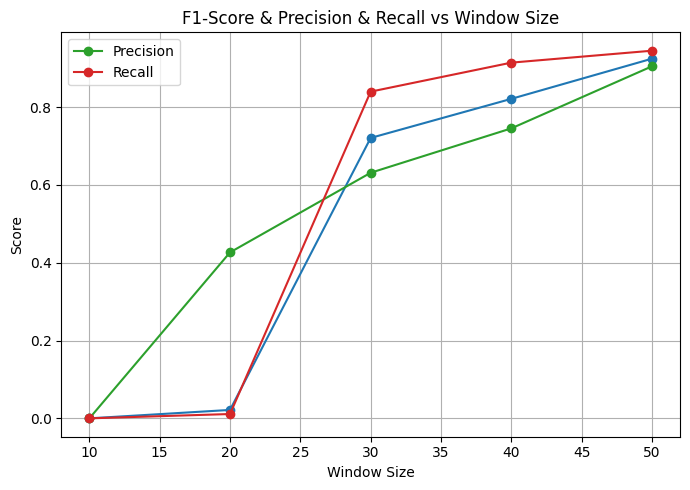

In [ ]:
plt.figure(figsize=(7,5))

plt.plot(result_df['Window size'], result_df['F1-Score'], marker='o', color='tab:blue')
plt.plot(result_df['Window size'], result_df['Precision'], marker='o', label='Precision', color='tab:green')
plt.plot(result_df['Window size'], result_df['Recall'], marker='o', label='Recall', color='tab:red')
plt.title('F1-Score & Precision & Recall vs Window Size')
plt.xlabel('Window Size')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
!pip install ultralytics

In [ ]:
import cv2
from ultralytics import YOLO

# ======================================
# YOLO 모델 로드
# ======================================
model = YOLO("yolov8s-pose.pt")
model.to("cuda")
model.fuse()  # 최적화

# keypoint 이름
kp_names = [
    "nose","left_eye","right_eye","left_ear","right_ear",
    "left_shoulder","right_shoulder","left_elbow","right_elbow",
    "left_wrist","right_wrist","left_hip","right_hip",
    "left_knee","right_knee","left_ankle","right_ankle"
]

# ======================================
# Skeleton batch 추출 함수
# ======================================
def extract_skeleton(video_path, batch_size=64):
    cap = cv2.VideoCapture(video_path)
    frame_idx = 0
    batch = []
    frame_data = []

    prev = [0.0] * (len(kp_names) * 3)  # 이전 프레임 보정용

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        batch.append(frame)

        if len(batch) == batch_size:
            results = model(batch, verbose=False)
            for r in results:
                if r.keypoints is not None and len(r.keypoints.xy) > 0:
                    keypoints = r.keypoints.xy[0].cpu().numpy()
                    conf = r.keypoints.conf[0].cpu().numpy()
                    sk = []
                    for i in range(17):
                        x, y = keypoints[i]
                        c = conf[i]
                        sk += [float(x), float(y), float(c)]
                    prev = sk
                else:
                    sk = prev
                frame_data.append((frame_idx, sk))
                frame_idx += 1
            batch = []

    # 남은 프레임 처리
    if len(batch) > 0:
        results = model(batch, verbose=False)
        for r in results:
            if r.keypoints is not None and len(r.keypoints.xy) > 0:
                keypoints = r.keypoints.xy[0].cpu().numpy()
                conf = r.keypoints.conf[0].cpu().numpy()
                sk = []
                for i in range(17):
                    x, y = keypoints[i]
                    c = conf[i]
                    sk += [float(x), float(y), float(c)]
                prev = sk
            else:
                sk = prev
            frame_data.append((frame_idx, sk))
            frame_idx += 1

    cap.release()
    return frame_data  # [(frame_idx, [x1,y1,c1,...,x17,y17,c17]), ...]

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
YOLOv8s-pose summary (fused): 81 layers, 11,615,724 parameters, 0 gradients, 30.2 GFLOPs


In [ ]:
# Skeleton 연결 구조 (COCO 17 keypoints 기준)
skeleton_connections = [
    (0,1),(0,2),(1,3),(2,4),
    (0,5),(0,6),(5,7),(7,9),
    (6,8),(8,10),(5,6),(5,11),
    (6,12),(11,12),(11,13),(13,15),
    (12,14),(14,16)
]

def predict_video_lstm(input_path, model, output_path, window_size=20, threshold=0.5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    # 1) skeleton 추출
    frames_skel = extract_skeleton(input_path)  # [(frame_idx, sk), ...]

    # 2) sliding window로 LSTM 예측
    sk_data = [sk for _, sk in frames_skel]
    sk_data = np.array(sk_data)
    preds = np.zeros(len(sk_data))

    for i in range(len(sk_data) - window_size + 1):
        seq = torch.tensor(sk_data[i:i+window_size]).float().unsqueeze(0).to(device)
        with torch.no_grad():
            logit = model(seq)
            prob = torch.sigmoid(logit).item()
            preds[i + window_size - 1] = prob  # 마지막 프레임에 값 할당

    # 3) 동영상 작성
    cap = cv2.VideoCapture(input_path)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = cap.get(cv2.CAP_PROP_FPS)
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret or frame_idx >= len(frames_skel):
            break

        _, sk = frames_skel[frame_idx]
        sk = np.array(sk).reshape(-1,3)

        # Skeleton 그리기
        for x,y,c in sk:
            cv2.circle(frame, (int(x), int(y)), 3, (0,255,0), -1)
        for i,j in skeleton_connections:
            x1,y1,_ = sk[i]
            x2,y2,_ = sk[j]
            cv2.line(frame, (int(x1),int(y1)), (int(x2),int(y2)), (0,255,0), 2)

        # Fall/Normal 및 예측값 표시
        prob = preds[frame_idx]
        label = "Fall" if prob > threshold else "Normal"
        cv2.putText(frame, f"{label} ({prob:.2f})", (30, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,0,255) if label=="Fall" else (0,255,0), 2)

        out.write(frame)
        frame_idx += 1

    cap.release()
    out.release()
    print("✅ Done:", output_path)


In [ ]:
input_path = '/content/drive/MyDrive/[Projects]/AI Hub/Pose Detection 기반 실시간 낙상 감지 시스템 개발/Data/data/낙상사고 위험동작 영상-센서 쌍 데이터_병원,후면낙상/3.개방데이터/1.데이터/Validation/01.원천데이터/VS/영상'

video_path = [
    '/Y/SY/00001_H_A_SY_C1/00001_H_A_SY_C1.mp4',
    '/Y/SY/00026_H_A_SY_C1/00026_H_A_SY_C1.mp4',
    '/Y/SY/00029_H_A_SY_C1/00029_H_A_SY_C1.mp4',
    '/Y/SY/00053_H_A_SY_C1/00053_H_A_SY_C1.mp4',
    '/Y/SY/00076_H_A_SY_C1/00076_H_A_SY_C1.mp4',
    '/N/N/00005_H_A_N_C1/00005_H_A_N_C1.mp4',
    '/N/N/00023_H_A_N_C1/00023_H_A_N_C1.mp4',
    '/N/N/00095_H_A_N_C1/00095_H_A_N_C1.mp4',
    '/N/N/00110_H_A_N_C1/00110_H_A_N_C1.mp4',
    '/N/N/00204_H_D_N_C1/00204_H_D_N_C1.mp4',
]

In [ ]:
for path in video_path:
    frames_skel = extract_skeleton(input_path + path)
    print("🔥 extracted frames:", len(frames_skel))

    predict_video_lstm(
        input_path + path,
        model_10,
        f"output_lstm_result_10_{path.split('/')[3]}.mp4",
        window_size=10,
        threshold=best_th_10
    )

🔥 extracted frames: 100
✅ Done: output_lstm_result_10_00001_H_A_SY_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_10_00026_H_A_SY_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_10_00029_H_A_SY_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_10_00053_H_A_SY_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_10_00076_H_A_SY_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_10_00005_H_A_N_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_10_00023_H_A_N_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_10_00095_H_A_N_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_10_00110_H_A_N_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_10_00204_H_D_N_C1.mp4


In [ ]:
for path in video_path:
    frames_skel = extract_skeleton(input_path + path)
    print("🔥 extracted frames:", len(frames_skel))

    predict_video_lstm(
        input_path + path,
        model_20,
        f"output_lstm_result_20_{path.split('/')[3]}.mp4",
        window_size=20,
        threshold=best_th_20
    )

🔥 extracted frames: 100
✅ Done: output_lstm_result_20_00001_H_A_SY_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_20_00026_H_A_SY_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_20_00029_H_A_SY_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_20_00053_H_A_SY_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_20_00076_H_A_SY_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_20_00005_H_A_N_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_20_00023_H_A_N_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_20_00095_H_A_N_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_20_00110_H_A_N_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_20_00204_H_D_N_C1.mp4


In [ ]:
for path in video_path:
    frames_skel = extract_skeleton(input_path + path)
    print("🔥 extracted frames:", len(frames_skel))

    predict_video_lstm(
        input_path + path,
        model_30,
        f"output_lstm_result_30_{path.split('/')[3]}.mp4",
        window_size=30,
        threshold=best_th_30
    )

🔥 extracted frames: 100
✅ Done: output_lstm_result_30_00001_H_A_SY_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_30_00026_H_A_SY_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_30_00029_H_A_SY_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_30_00053_H_A_SY_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_30_00076_H_A_SY_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_30_00005_H_A_N_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_30_00023_H_A_N_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_30_00095_H_A_N_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_30_00110_H_A_N_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_30_00204_H_D_N_C1.mp4


In [ ]:
for path in video_path:
    frames_skel = extract_skeleton(input_path + path)
    print("🔥 extracted frames:", len(frames_skel))

    predict_video_lstm(
        input_path + path,
        model_40,
        f"output_lstm_result_40_{path.split('/')[3]}.mp4",
        window_size=40,
        threshold=best_th_40
    )

🔥 extracted frames: 100
✅ Done: output_lstm_result_40_00001_H_A_SY_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_40_00026_H_A_SY_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_40_00029_H_A_SY_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_40_00053_H_A_SY_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_40_00076_H_A_SY_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_40_00005_H_A_N_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_40_00023_H_A_N_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_40_00095_H_A_N_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_40_00110_H_A_N_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_40_00204_H_D_N_C1.mp4


In [ ]:
for path in video_path:
    frames_skel = extract_skeleton(input_path + path)
    print("🔥 extracted frames:", len(frames_skel))

    predict_video_lstm(
        input_path + path,
        model_50,
        f"output_lstm_result_50_{path.split('/')[3]}.mp4",
        window_size=50,
        threshold=best_th_50
    )

🔥 extracted frames: 100
✅ Done: output_lstm_result_50_00001_H_A_SY_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_50_00026_H_A_SY_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_50_00029_H_A_SY_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_50_00053_H_A_SY_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_50_00076_H_A_SY_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_50_00005_H_A_N_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_50_00023_H_A_N_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_50_00095_H_A_N_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_50_00110_H_A_N_C1.mp4
🔥 extracted frames: 100
✅ Done: output_lstm_result_50_00204_H_D_N_C1.mp4


In [19]:
def evaluate_metrics(window, y_val, preds, probs, fps=30, true_fall_frame=None):

    # confusion matrix
    cm = confusion_matrix(y_val, preds)
    tn, fp, fn, tp = cm.ravel()

    # scores
    precision = precision_score(y_val, preds, zero_division=0)
    recall    = recall_score(y_val, preds, zero_division=0)
    f1        = f1_score(y_val, preds, zero_division=0)

    # latency (sec)
    latency = window / fps

    # FP / FN rates
    miss_rate = fn / (tp + fn + 1e-8)
    false_alarm_rate = fp / (tn + fp + 1e-8)

    # cost score
    cost_score = fp * 1 + fn * 10

    # smoothness (예측 확률 variance)
    smoothness = np.var(probs)

    # detection delay
    detection_delay = None
    if (true_fall_frame is not None):
        pred_fall_frame = np.argmax(preds == 1)
        detection_delay = pred_fall_frame - true_fall_frame

    return {
        "Window": window,
        "F1": f1,
        "Precision": precision,
        "Recall": recall,
        "Latency_sec": latency,
        "Miss_rate": miss_rate,
        "False_alarm_rate": false_alarm_rate,
        "Cost_score": cost_score,
        "Smoothness": smoothness,
        "Detection_delay": detection_delay
    }

In [20]:
def predict_proba(model, x):
    model.eval()
    device = next(model.parameters()).device
    x = torch.tensor(x).float().to(device)

    with torch.no_grad():
        logits = model(x)
        probs = torch.sigmoid(logits).cpu().numpy().flatten()

    return probs

In [21]:
results = []

for window in [10, 20, 30, 40, 50]:

    model = window_to_model[window]

    probs = predict_proba(model, x_val)
    preds = (probs > window_to_threshold[window]).astype(int)

    if np.sum(y_val) > 0:
        gt_fall_frame = np.argmax(y_val == 1)
    else:
        gt_fall_frame = None

    metrics = evaluate_metrics(
        window=window,
        y_val=y_val,
        preds=preds,
        probs=probs,
        fps=10,
        true_fall_frame=gt_fall_frame
    )

    results.append(metrics)

result_df = pd.DataFrame(results)
result_df

,Window,F1,Precision,Recall,Latency_sec,Miss_rate,False_alarm_rate,Cost_score,Smoothness,Detection_delay
0,10,0.000000,0.000000,0.000000,1.0,1.000000,0.000000,136320,0.042131,-9
1,20,0.026628,0.978723,0.013498,2.0,0.986502,0.000242,134484,0.078224,4310
2,30,0.926886,0.954669,0.900675,3.0,0.099325,0.035205,14123,0.106529,4
3,40,0.909078,0.879553,0.940654,4.0,0.059346,0.106039,9846,0.141878,4
4,50,0.924435,0.904762,0.944982,5.0,0.055018,0.081884,8856,0.181949,4


In [24]:
result_df.to_csv('./results_lstm.csv', index=False)
pd.read_csv('results_lstm.csv')

,Window,F1,Precision,Recall,Latency_sec,Miss_rate,False_alarm_rate,Cost_score,Smoothness,Detection_delay
0,10,0.000000,0.000000,0.000000,1.0,1.000000,0.000000,136320,0.042131,-9
1,20,0.026628,0.978723,0.013498,2.0,0.986502,0.000242,134484,0.078224,4310
2,30,0.926886,0.954669,0.900675,3.0,0.099325,0.035205,14123,0.106529,4
3,40,0.909078,0.879553,0.940654,4.0,0.059346,0.106039,9846,0.141878,4
4,50,0.924435,0.904762,0.944982,5.0,0.055018,0.081884,8856,0.181949,4
